# 特征工程

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mglearn
import torch
import torch.nn as nn

# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
plt.rcParams['font.sans-serif']=['Times New Roman']
plt.rc('axes', unicode_minus=False)
#建立Features
datasets=pd.read_table("PEER_Dataset.txt",sep='\s+')
datasets=pd.DataFrame(datasets)
feature=datasets.iloc[:,0:13]
#特征归一化
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

scaler=MinMaxScaler(feature_range=(0,1))
feature=scaler.fit_transform(feature)

# scaler = StandardScaler()
# feature=scaler.fit_transform(feature)

# feature=pd.DataFrame(feature)

#建立Targets
target=[]
labels=["Flexure","Flexure-Shear","Shear"]
for i in datasets.iloc[:,13]:
    if i=="Flexure":
        target.append(0)
    if i == "Flexure-Shear":
        target.append(1)
    if i=="Shear":
        target.append(2)

#样本划分
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(feature,target,random_state=666,test_size=0.3)

draw_color=np.array([])
for i in target:
    if i==0:
        draw_color=np.append(draw_color,'#283c63')
    if i==1:
        draw_color=np.append(draw_color,'#07689f')
    if i==2:
        draw_color=np.append(draw_color,'#f85f73')

# Deep Learning--DNN

In [11]:
import torch.nn as nn
import torch
class NetDepth(nn.Module):
    def __init__(self, n_chansl=13):
        super().__init__()
        self.n_chansl = n_chansl
        self.fc1 = nn.Linear(n_chansl, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 32)
        self.fc5 = nn.Linear(32, 32)
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, 3)
        self.LeakyReLU=nn.GELU()
        self.Dropout=nn.Dropout(0.01)
        self.LayerNorm32 = nn.LayerNorm(32)

    def forward(self, x):
        out = x.view(-1, self.n_chansl)
        out = self.LeakyReLU(self.fc1(out))
        out = self.LayerNorm32(out)

        out = self.LeakyReLU(self.fc2(out))
        out = self.Dropout(out)
        out = self.LayerNorm32(out)

        out = self.LeakyReLU(self.fc3(out))
        out = self.Dropout(out)
        out = self.LayerNorm32(out)

        out = self.LeakyReLU(self.fc4(out))
        out = self.Dropout(out)
        out = self.LayerNorm32(out)

        out = self.LeakyReLU(self.fc5(out))
        out = self.Dropout(out)

        out = self.LeakyReLU(self.fc6(out))
        out = self.Dropout(out)
        out = self.fc7(out)
        return out

import torch.optim as optim
def training_loop_l2reg(n_epochs,optimizer,model,loss_fn,X_train,y_train):
    total_params = sum(p.numel() for p in model.parameters())
    print(f'{total_params:,} total parameters.')
    loss_tensor = torch.tensor([]).to(device=device)
    step_tensor = torch.tensor([]).to(device=device)

    NUM=torch.tensor([range(1, n_epochs + 1)]).to(device=device)

    for epoch in NUM[0]:

        data=X_train
        target=y_train
        data = data.to(device=device)
        target = target.to(device=device).unsqueeze(1)
        outputs = model(data)

        loss = loss_fn(outputs.squeeze(), target.flatten().long()).to(device=device)
        # l2_lambda = 0.001
        # l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
        # loss = loss + l2_lambda * l2_norm
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        average_loss = loss

        step_tensor=torch.cat((step_tensor,epoch.unsqueeze(0)))
        loss_tensor=torch.cat((loss_tensor,average_loss.unsqueeze(0)))

        if epoch == 1 or epoch % 100 == 0:
            print(f"epoch:{epoch}, Training loss:{loss}")
    step_list=step_tensor.cpu().detach().numpy()
    loss_list=loss_tensor.cpu().detach().numpy()
    out_save = np.hstack([step_list.reshape(-1,1), loss_list.reshape(-1,1)])
    np.savetxt("Loss.txt",out_save[::10,:])


# Train

In [12]:
X_train = torch.from_numpy(X_train).to(torch.float)
y_train = torch.tensor(y_train).to(torch.float)
X_test = torch.from_numpy(X_test).to(torch.float)
y_test = torch.tensor(y_test).to(torch.float)

device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
model=NetDepth().to(device=device)
# optimizer=optim.SGD(model.parameters(),lr=1e-3)
optimizer=optim.Adam(model.parameters(),lr=1e-3)
# optimizer=optim.RMSprop(model.parameters(),lr=1e-4)
loss_fn=nn.CrossEntropyLoss()
training_loop_l2reg(
    n_epochs=30000,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    X_train=X_train,
    y_train=y_train
)

torch.save({'model': model.state_dict()}, 'model.pth')

5,315 total parameters.
epoch:1, Training loss:1.1429765224456787
epoch:100, Training loss:0.24032622575759888
epoch:200, Training loss:0.06893312186002731
epoch:300, Training loss:0.03381277620792389
epoch:400, Training loss:0.0343472920358181
epoch:500, Training loss:0.025089489296078682
epoch:600, Training loss:0.023445595055818558
epoch:700, Training loss:0.024609318003058434
epoch:800, Training loss:0.025820720940828323
epoch:900, Training loss:0.026365257799625397
epoch:1000, Training loss:0.03149687498807907
epoch:1100, Training loss:0.019964022561907768
epoch:1200, Training loss:0.024744609370827675
epoch:1300, Training loss:0.023705752566456795
epoch:1400, Training loss:0.02320004254579544
epoch:1500, Training loss:0.02325437031686306
epoch:1600, Training loss:0.02437424473464489
epoch:1700, Training loss:0.026704074814915657
epoch:1800, Training loss:0.027307022362947464
epoch:1900, Training loss:0.02720114216208458
epoch:2000, Training loss:0.02337813191115856
epoch:2100, Tr

# Test

In [13]:
resnet = NetDepth()
resnet.load_state_dict(torch.load('model.pth')["model"])
predict = resnet(X_test).squeeze(1)
_, predict = torch.max(predict, dim=1)
print(predict, y_test)
acc = 0
for i, j in zip(predict, y_test):
    if i == j:
        acc += 1
print(acc / y_test.size(0) * 100)

tensor([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0,
        0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 0]) tensor([1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0.,
        0., 0., 0., 2., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
        0., 0., 0.])
97.33333333333334


# Confusion matrix

Text(0, 0.5, 'Practical results')

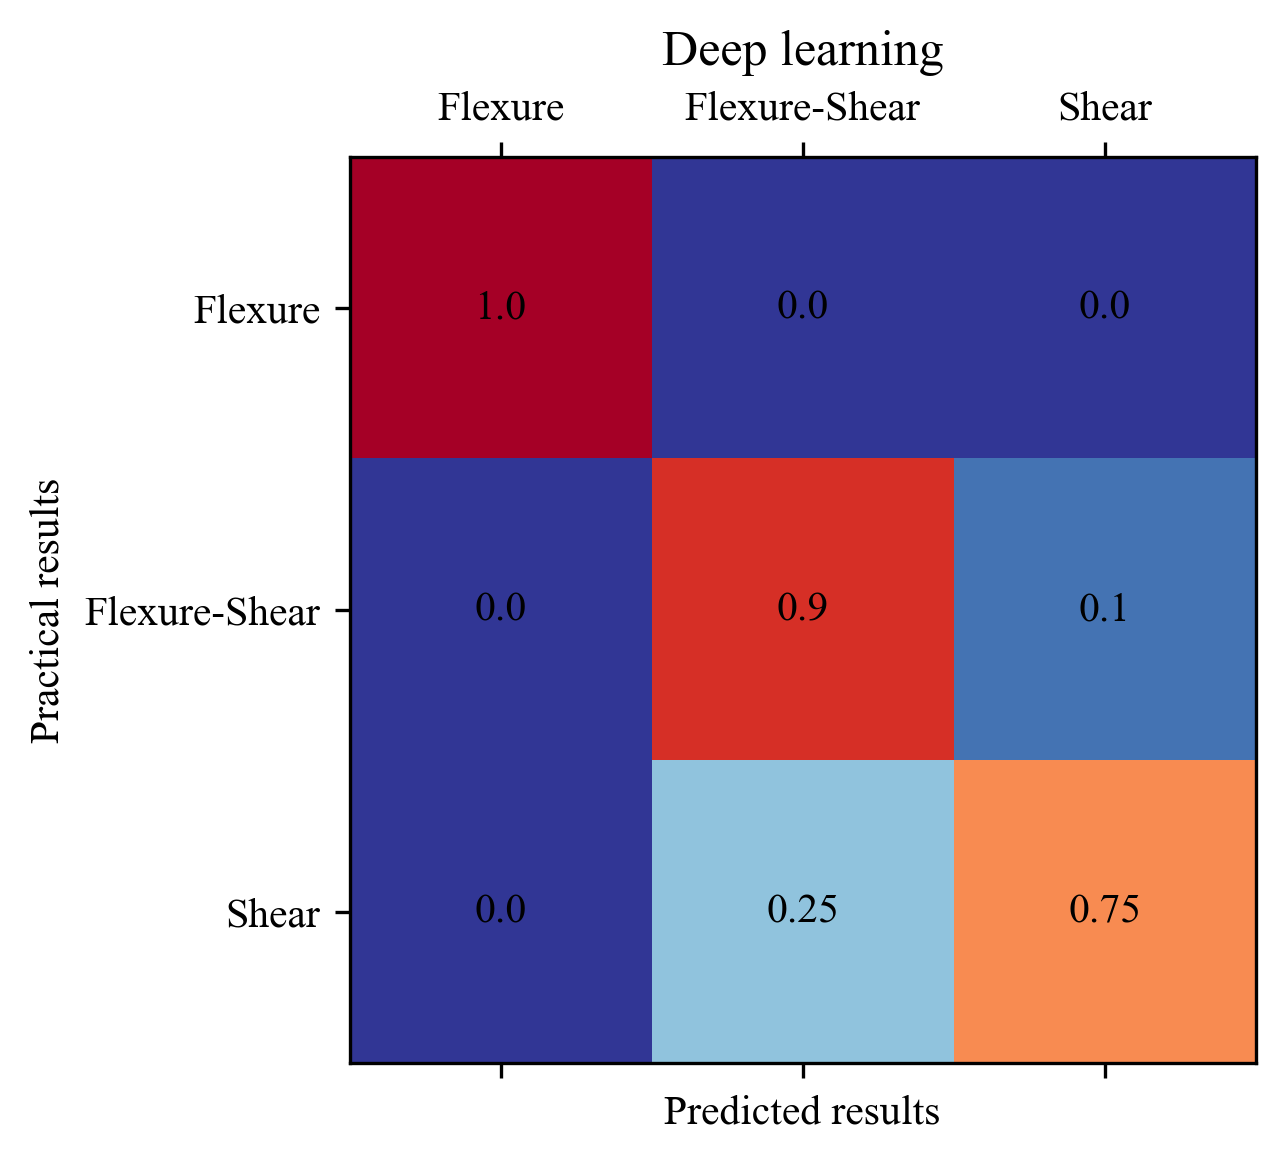

In [15]:
from sklearn.metrics import confusion_matrix
conf_mx = confusion_matrix(y_test, predict, labels=[0, 1, 2])
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

fig, ax = plt.subplots(dpi=300)
ax.matshow(norm_conf_mx, cmap="RdYlBu_r")

for i in range(3):
    for j in range(3):
        text = ax.text(j, i, round(norm_conf_mx[i, j], 2), ha="center", va="center", color="k")

ax.set_title("Deep learning")
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel("Predicted results")
ax.set_ylabel("Practical results")

# Loss

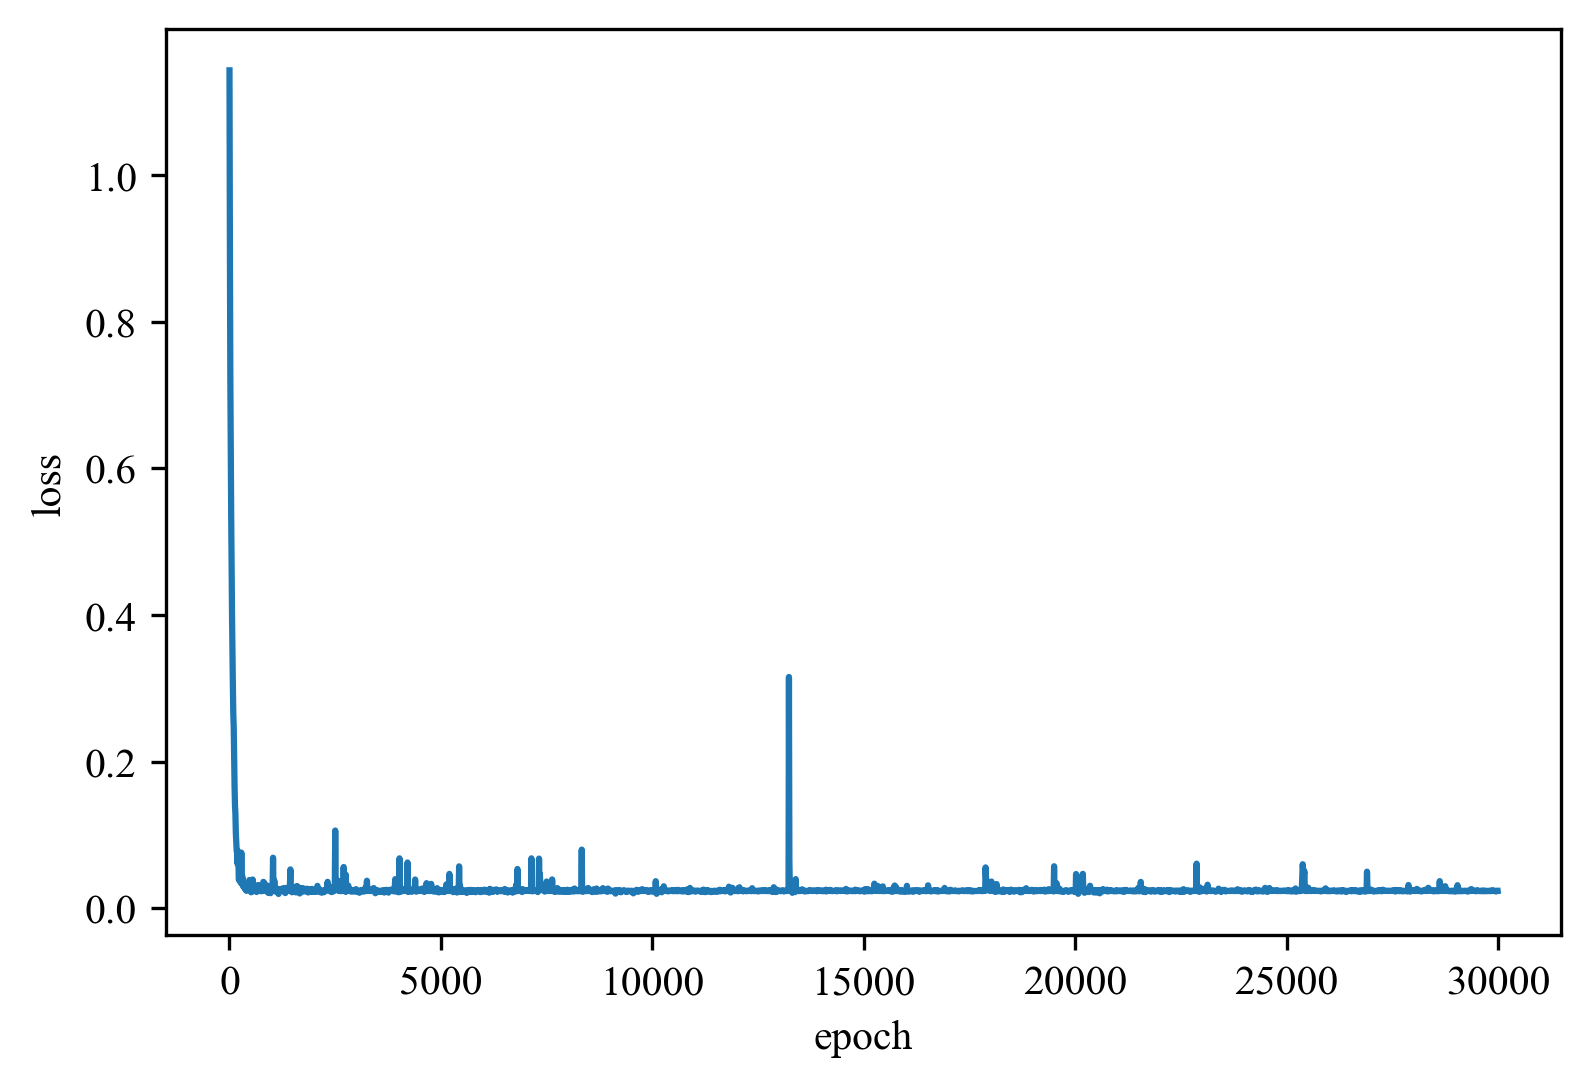

In [22]:
Loss=np.loadtxt('Loss.txt')
Loss=pd.DataFrame(Loss)
Loss.columns=['epoch','loss']
import seaborn as sns
fig=plt.subplots(dpi=300)
sns.lineplot(x='epoch',y='loss',data=Loss)
plt.show()